# Import Library

In [1]:
# Pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, to_date, to_timestamp, when, expr, date_trunc, count, avg
from pyspark.sql.functions import explode, split, trim
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import count as Fcount
from pyspark.sql.window import Window 
import geopandas as gpd

spark = SparkSession.builder \
    .appName("BNPL_Part234_Data") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/18 13:41:07 WARN Utils: Your hostname, xuzhengs-MacBook-Pro-2.local, resolves to a loopback address: 127.0.0.1; using 10.5.82.157 instead (on interface en0)
25/09/18 13:41:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/18 13:41:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data Check - Part 2 & 3 & 4

In [2]:
p2_path = "part2_data/transaction2021A"
p2_df = spark.read.parquet(p2_path)

p3_path = "part3_data/transaction2021B"
p3_df = spark.read.parquet(p3_path)

p4_path = "part4_data/transaction2022A"
p4_df = spark.read.parquet(p4_path)

new_tbl_consumer = (
    spark.read
         .option("header", True)   
         .option("inferSchema", True)
         .csv("part1_data/new_tbl_consumer.csv")
)
consumer_details = spark.read.parquet("part1_data/consumer_user_details.parquet")

### 赵航宇数据
#preprocessed_data = spark.read.parquet("preprocessed_data.parquet")

crime_df = (
    spark.read
        .option("header", True)   
        .option("inferSchema", True)
        .csv("external_data/comprehensive_crime_rate.csv")
)

# income
income_df = (
    spark.read
        .option("header", True)   
        .option("inferSchema", True)
        .csv("external_data/income.csv")
)

# employed rate
employed_rate = (
    spark.read
        .option("header", True)   
        .option("inferSchema", True)
        .csv("external_data/employed_rate.csv")
)


# consumer_file
consumer_level = spark.read.parquet("part1_data/consumer_profile.parquet")

# merchant file
merchant_level = spark.read.parquet("part1_data/merchant_profile.parquet")

# SA3_Map
gdf = gpd.read_file("external_data/State_Map/State_Map.shp")

In [3]:
p2_df.show(10)
p2_df.count()

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
|      3| 76819856970|  448.529684285612|5ace6a24-cdf0-4aa...|    2021-08-20|
|  18479| 67609108741|  86.4040605836911|d0e180f0-cb06-42a...|    2021-08-20|
|      3| 34096466752| 301.5793450525113|6fb1ff48-24bb-4f9...|    2021-08-20|
|  18482| 70501974849| 68.75486276223054|8505fb33-b69a-412...|    2021-08-20|
|      4| 49891706470| 48.89796461900801|ed11e477-b09f-4ae...|  

3643266

In [4]:
p3_df.show(10)
p3_df.count()

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  14935| 79417999332|136.06570809815838|23acbb7b-cf98-458...|    2021-11-26|
|      1| 46451548968| 72.61581642788431|76bab304-fa2d-400...|    2021-11-26|
|  14936| 89518629617|3.0783487174439297|a2ae446a-2959-41c...|    2021-11-26|
|      1| 49167531725| 51.58228625503599|7080c274-17f7-4cc...|    2021-11-26|
|  14936| 31101120643|25.228114942417797|8e301c0f-06ab-45c...|    2021-11-26|
|      2| 67978471888| 691.5028234458998|0380e9ad-b0e8-420...|    2021-11-26|
|  14936| 60956456424|102.13952056640888|5ac3da9c-5147-452...|    2021-11-26|
|      2| 47644196714| 644.5220654863093|4e368e44-86f8-4de...|    2021-11-26|
|  14938| 39649557865|209.12780951421405|4d78cd01-4bab-494...|    2021-11-26|
|      3| 88402174457| 141.0387993699113|c50c957d-ecfc-430...|  

4508106

In [5]:
p4_df.show(10)
p4_df.count() 

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  11139| 96152467973|16.213590228273233|785b0080-9e4b-471...|    2022-08-20|
|      1| 98973094975| 86.97955945703498|2560f7b0-ee5d-4b3...|    2022-08-20|
|  11139| 56762458844|31.513502323509194|0311717b-8b5b-410...|    2022-08-20|
|      1| 89502033586|124.18468694868491|f8891626-f098-45b...|    2022-08-20|
|  11139| 96161808980|61.620445567668966|d90a421f-f1da-4bf...|    2022-08-20|
|      2| 72472909171| 32.26524985312485|523e0403-b677-450...|    2022-08-20|
|  11139| 91923722701|11.331586767322225|f45a842b-0366-41d...|    2022-08-20|
|      3| 46380096952|119.80011239189334|58d0f423-037c-43f...|    2022-08-20|
|  11140| 79283124876|198.13027742225435|60b12d41-41d6-4c1...|    2022-08-20|
|      4| 67202032418|206.20865323560022|64a05a23-a078-481...|  

6044133

In [6]:
new_tbl_consumer.show(5, truncate=False)

+-----------------+-----------------------------+-----+--------+------+-----------+
|name             |address                      |state|postcode|gender|consumer_id|
+-----------------+-----------------------------+-----+--------+------+-----------+
|Yolanda Williams |413 Haney Gardens Apt. 742   |WA   |6935    |Female|1195503    |
|Mary Smith       |3764 Amber Oval              |NSW  |2782    |Female|179208     |
|Jill Jones MD    |40693 Henry Greens           |NT   |862     |Female|1194530    |
|Lindsay Jimenez  |00653 Davenport Crossroad    |NSW  |2780    |Female|154128     |
|Rebecca Blanchard|9271 Michael Manors Suite 651|WA   |6355    |Female|712975     |
+-----------------+-----------------------------+-----+--------+------+-----------+
only showing top 5 rows


In [7]:
income_df.show(5)


+--------+---------------+------------------+----------------+
|POSTCODE|2021 Population|Median ($) 2021-22|Mean ($) 2021-22|
+--------+---------------+------------------+----------------+
|     800|        28507.0|           69920.0|         83232.0|
|     810|        57630.0|           66937.0|         76136.0|
|     812|        57630.0|           66937.0|         76136.0|
|     820|        43068.5|           68428.5|         79684.0|
|     822|        26735.0|           56840.4|         67317.8|
+--------+---------------+------------------+----------------+
only showing top 5 rows


In [8]:
employed_rate.show(5)

+-------------------+------+------+------+------+------+------+------+------+
|              Month|   NSW|   VIC|   QLD|    SA|    WA|   TAS|    NT|   ACT|
+-------------------+------+------+------+------+------+------+------+------+
|2021-01-01 00:00:00|60.988|62.132|61.688| 57.76|63.254|57.538|69.138|67.904|
|2021-02-01 00:00:00|61.466|62.325|61.868|57.832|62.932|58.095|69.698|68.784|
|2021-03-01 00:00:00|61.896|62.467|62.284|57.852|64.531|58.045|69.062|68.194|
|2021-04-01 00:00:00|61.469|62.511|62.173|58.808|64.168|57.768|69.624|68.718|
|2021-05-01 00:00:00| 62.28|62.927|62.583|59.194|64.375|57.936|70.001|68.845|
+-------------------+------+------+------+------+------+------+------+------+
only showing top 5 rows


In [9]:
crime_df.show(10)

+-----+----+-------+--------+----------+--------------+-----------+
|State|Year|Assault|Homicide|Kidnapping|Sexual assault|Crime_Index|
+-----+----+-------+--------+----------+--------------+-----------+
|  ACT|2021|  511.4|     2.7|       0.0|          75.4|      271.3|
|  ACT|2022|  538.7|     2.0|       0.7|          71.2|      284.1|
|  NSW|2021|  798.9|     1.0|       2.6|         141.8|      428.3|
|  NSW|2022|  852.0|     1.0|       2.6|         152.2|      456.9|
|   NT|2021| 3648.6|     5.2|       0.0|         143.1|     1854.0|
|   NT|2022| 4159.1|     6.0|       2.0|         144.4|     2109.8|
|  QLD|2021|    0.0|     1.6|       0.5|         132.1|       26.8|
|  QLD|2022|  983.3|     2.1|       0.8|         139.5|      520.0|
|   SA|2021| 1008.2|     1.9|       2.3|          98.9|      524.5|
|   SA|2022| 1083.8|     1.6|       2.3|          99.7|      562.4|
+-----+----+-------+--------+----------+--------------+-----------+
only showing top 10 rows


# Data Preprocessing

In [10]:
# %%
# Import dependencies
import pandas as pd
import pyarrow
from tqdm.auto import tqdm
import glob
import json
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# Step 1: 合并三个 DataFrame
transactions_df = (
    p2_df.unionByName(p3_df)
         .unionByName(p4_df)
)

# Step 2: 检查结果 
transactions_df.printSchema()
print(f"Total rows: {transactions_df.count()}")  
transactions_df.show(10, truncate=False)

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)

Total rows: 14195505
+-------+------------+------------------+------------------------------------+--------------+
|user_id|merchant_abn|dollar_value      |order_id                            |order_datetime|
+-------+------------+------------------+------------------------------------+--------------+
|18478  |62191208634 |63.255848959735246|949a63c8-29f7-4ab0-ada4-99ac50a88952|2021-08-20    |
|2      |15549624934 |130.3505283105634 |6a84c3cf-612a-4574-835b-144a47353eff|2021-08-20    |
|18479  |64403598239 |120.15860593212783|b10dcc33-e53f-4254-863c-de5266810cbc|2021-08-20    |
|3      |60956456424 |136.6785200286976 |0f09c5a5-784e-4477-b049-8ee4dd069b7b|2021-08-20    |
|18479  |94493496784 |72.96316578355305 |f6c78c1a-4600-4c5f-8e97-6e9eb534b586|2021-08-20    |
|3      |76819

In [12]:
# Step 3: 在 Spark DataFrame 里做分布检查（不用转 Pandas）

# 时间分布（如果有 order_date 列）
if "order_date" in transactions_df.columns:
    daily_counts = (
        transactions_df.groupBy("order_date")
        .count()
        .orderBy("order_date")
    )
    daily_counts.show(10, truncate=False)

# 金额分布（找价格相关列）
price_cols = [c for c in transactions_df.columns if "price" in c or "amount" in c or "total" in c]
if price_cols:
    transactions_df.select(price_cols[0]).describe().show()

# Step 4: 标准化列名
def normalize_columns_spark(df):
    for c in df.columns:
        new_name = c.strip().lower().replace(" ", "_")
        df = df.withColumnRenamed(c, new_name)
    return df

transactions_df = normalize_columns_spark(transactions_df)
print("Column examples:", transactions_df.columns[:40])

# Step 5: 识别时间列
time_candidates = [c for c in transactions_df.columns if "order" in c and ("time" in c or "date" in c or "datetime" in c)]
if not time_candidates:
    time_candidates = [c for c in transactions_df.columns if c in ("created_at","created","timestamp","ts","date","datetime")]

print("Time list candidates:", time_candidates)
time_col = time_candidates[0] if time_candidates else None
print("Use the time column:", time_col)

# Step 6: 每日订单统计并保存
if time_col:
    daily = (
        transactions_df.groupBy(time_col)
        .count()
        .withColumnRenamed("count", "order_count")
        .orderBy(time_col)
    )

    print("daily head:")
    daily.show(10, truncate=False)


Column examples: ['user_id', 'merchant_abn', 'dollar_value', 'order_id', 'order_datetime']
Time list candidates: ['order_datetime']
Use the time column: order_datetime
daily head:
+--------------+-----------+
|order_datetime|order_count|
+--------------+-----------+
|2021-02-28    |17107      |
|2021-03-01    |15170      |
|2021-03-02    |15417      |
|2021-03-03    |16093      |
|2021-03-04    |16988      |
|2021-03-05    |17697      |
|2021-03-06    |16924      |
|2021-03-07    |16798      |
|2021-03-08    |16262      |
|2021-03-09    |15972      |
+--------------+-----------+
only showing top 10 rows


# Final Data Merge (External Data)

In [13]:
from pyspark.sql.functions import col

# Step 1: 给右边的列改名，避免重复
trans_dates = transactions_df.select("order_id", col("order_datetime").alias("order_datetime_ref"))

# Step 2: join
preprocessed_data = (
    transactions_df
    .join(trans_dates, on="order_id", how="left")
)

# Step 3: 检查
preprocessed_data.show(10, truncate=False)


+------------------------------------+-------+------------+------------------+--------------+------------------+
|order_id                            |user_id|merchant_abn|dollar_value      |order_datetime|order_datetime_ref|
+------------------------------------+-------+------------+------------------+--------------+------------------+
|01d968a6-dde1-48cf-96dc-5f504aa47177|14935  |72472909171 |52.973387548612614|2021-12-01    |2021-12-01        |
|0371006a-d7a1-487d-b6cd-d726d0888488|22286  |17945458645 |125.48815344185114|2022-08-15    |2022-08-15        |
|066d9342-9bc7-4be2-80a0-3fad03dabc56|11139  |45466221547 |0.8459119362003027|2022-07-12    |2022-07-12        |
|3077e589-1629-4af0-9d72-f6af9c54a589|14942  |24852446429 |17.276891684035274|2021-09-09    |2021-09-09        |
|3dba1ecb-1d9e-415f-9924-f86b6bc50119|18482  |47529937246 |110.27705449024003|2021-05-24    |2021-05-24        |
|4b0819d9-f52a-457d-ade9-b5375780eaf7|22283  |96491286698 |206.28273891130056|2022-08-15    |202

In [14]:
### Add the coloumn of postcode/state/gender
# Join user_id with consumer_id to enrich transaction data
df_with_consumer = (
    preprocessed_data
    .join(consumer_details, on="user_id", how="left")
)

# Join consumer_id with the cleaned consumer demographic table
df_enriched = (
    df_with_consumer
    .join(new_tbl_consumer, on="consumer_id", how="left")
)

# Select only the required fields for the final dataset
df_enriched_selected = df_enriched.select(
    "user_id",
    "consumer_id",
    "merchant_abn",
    "order_id",
    "dollar_value",
    "state",
    "postcode",
    "gender",
    "order_datetime"
)

# Preview first 10 rows of the enriched dataset 
df_enriched_selected.show(10, truncate=False)

+-------+-----------+------------+------------------------------------+------------------+-----+--------+------+--------------+
|user_id|consumer_id|merchant_abn|order_id                            |dollar_value      |state|postcode|gender|order_datetime|
+-------+-----------+------------+------------------------------------+------------------+-----+--------+------+--------------+
|14937  |4932       |20985347699 |0bed3901-f0a8-4aa9-b286-2126cf021021|11.197796935848178|NSW  |2530    |Female|2021-09-09    |
|14937  |4932       |48534649627 |16733b8a-d91a-436e-abce-02f27b990d1d|214.89416304714123|NSW  |2530    |Female|2022-02-07    |
|11139  |505718     |45466221547 |066d9342-9bc7-4be2-80a0-3fad03dabc56|0.8459119362003027|NSW  |2281    |Female|2022-07-12    |
|11139  |505718     |28687004922 |3948f702-0668-4cff-bae1-393868859cfc|19.65330763420652 |NSW  |2281    |Female|2022-07-08    |
|11139  |505718     |56762458844 |0311717b-8b5b-410b-89f3-f6e984b54a30|31.513502323509194|NSW  |2281    

In [15]:
### Insert the column with employed rate

# Step 1: reshape employed_rate from wide to long format
employed_long = (
    employed_rate
    .selectExpr("Month", "stack(8, 'NSW', NSW, 'VIC', VIC, 'QLD', QLD, 'SA', SA, 'WA', WA, 'TAS', TAS, 'NT', NT, 'ACT', ACT) as (state, employed_rate)")
)

# Step 2: 对交易数据生成 Year-Month
df_enriched_selected = df_enriched_selected.withColumn(
    "year_month",
    F.date_format("order_datetime", "yyyy-MM")
)

# Step 3: join
df_with_employed = (
    df_enriched_selected
    .join(employed_long.withColumnRenamed("Month", "year_month"), 
          on=["year_month", "state"], how="left")
)

# Step 4: 预览
df_with_employed.show(20, truncate=False)


+----------+-----+-------+-----------+------------+------------------------------------+------------------+--------+-----------+--------------+-------------+
|year_month|state|user_id|consumer_id|merchant_abn|order_id                            |dollar_value      |postcode|gender     |order_datetime|employed_rate|
+----------+-----+-------+-----------+------------+------------------------------------+------------------+--------+-----------+--------------+-------------+
|2021-09   |NSW  |14937  |4932       |20985347699 |0bed3901-f0a8-4aa9-b286-2126cf021021|11.197796935848178|2530    |Female     |2021-09-09    |58.681       |
|2022-02   |NSW  |14937  |4932       |48534649627 |16733b8a-d91a-436e-abce-02f27b990d1d|214.89416304714123|2530    |Female     |2022-02-07    |62.468       |
|2022-07   |VIC  |11     |428325     |88279777843 |3cd13626-cf47-44c0-94f7-b4105f6403bf|604.9188592638876 |3063    |Undisclosed|2022-07-13    |64.182       |
|2022-02   |VIC  |11     |428325     |81761494572 |0

In [16]:
### Insert the column with income
# 规范列名 + 类型（去掉空格/符号，转成小写）
income_df = (
    income_df
    .withColumnRenamed("POSTCODE", "postcode")
    .withColumnRenamed("2021 Population", "pop")
    .withColumnRenamed("Median ($) 2021-22", "median_income")
    .withColumnRenamed("Mean ($) 2021-22",   "mean_income")
    # 如果读进来是字符串，做一次安全的数值转换（去逗号）
    .withColumn("postcode", F.regexp_replace(F.col("postcode").cast("string"), r"\s+", "").cast("int"))
    .withColumn("pop", F.regexp_replace(F.col("pop").cast("string"), r"[,\s]", "").cast("double"))
    .withColumn("median_income", F.regexp_replace(F.col("median_income").cast("string"), r"[,\s]", "").cast("double"))
    .withColumn("mean_income",   F.regexp_replace(F.col("mean_income").cast("string"), r"[,\s]", "").cast("double"))
    .dropna(subset=["postcode"])       # 必要时：去掉没有邮编的行
)

# 若同一邮编在文件中出现多行，取一个稳定聚合（这里取最大人口那行）
w = F.row_number().over(Window.partitionBy("postcode").orderBy(F.col("pop").desc_nulls_last()))
income_df = income_df.withColumn("rn", w).filter("rn = 1").drop("rn")

df_with_income = (
    df_enriched_selected
    .join(income_df, on="postcode", how="left")
)

In [17]:
df_with_income.show(10)

+--------+-------+-----------+------------+--------------------+------------------+-----+------+--------------+----------+--------+-------------+-----------+
|postcode|user_id|consumer_id|merchant_abn|            order_id|      dollar_value|state|gender|order_datetime|year_month|     pop|median_income|mean_income|
+--------+-------+-----------+------------+--------------------+------------------+-----+------+--------------+----------+--------+-------------+-----------+
|    2530|  14937|       4932| 20985347699|0bed3901-f0a8-4aa...|11.197796935848178|  NSW|Female|    2021-09-09|   2021-09| 39938.0|      53068.0|    64132.0|
|    2530|  14937|       4932| 48534649627|16733b8a-d91a-436...|214.89416304714123|  NSW|Female|    2022-02-07|   2022-02| 39938.0|      53068.0|    64132.0|
|    2281|  11139|     505718| 45466221547|066d9342-9bc7-4be...|0.8459119362003027|  NSW|Female|    2022-07-12|   2022-07|126606.0|      55824.0|    69320.0|
|    2281|  11139|     505718| 28687004922|3948f702-

In [18]:
### Insert the column with crime rate
# Step 1: 给交易数据加 year 字段
df_with_income = df_with_income.withColumn(
    "year", F.year("order_datetime")
)

# Step 2: 统一 state 列名
crime_df = crime_df.withColumnRenamed("State", "state")

# Step 3: join
df_with_crime = (
    df_with_income
    .join(crime_df, on=["state", "year"], how="left")
)

# Step 4: 查看结果
df_with_crime.show(10, truncate=False)

+-----+----+--------+-------+-----------+------------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+
|state|year|postcode|user_id|consumer_id|merchant_abn|order_id                            |dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|Assault|Homicide|Kidnapping|Sexual assault|Crime_Index|
+-----+----+--------+-------+-----------+------------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+
|NSW  |2021|2530    |14937  |4932       |20985347699 |0bed3901-f0a8-4aa9-b286-2126cf021021|11.197796935848178|Female|2021-09-09    |2021-09   |39938.0 |53068.0      |64132.0    |798.9  |1.0     |2.6       |141.8         |428.3      |
|NSW  |2022|2530    |14937  |4932       |48534649627 |16733b8a-d

### Join with consumer_profile

In [19]:
# --- Join with Consumer Level ---
df_with_consumer = (
    df_with_crime
    .join(consumer_level, on="consumer_id", how="left")
)


In [20]:
# 预览
df_with_consumer.show(10, truncate=False)

+-----------+-----+----+--------+-------+------------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+---------+------------------+-------+
|consumer_id|state|year|postcode|user_id|merchant_abn|order_id                            |dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|Assault|Homicide|Kidnapping|Sexual assault|Crime_Index|c_user_id|c_fraud_prob      |c_state|
+-----------+-----+----+--------+-------+------------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+---------+------------------+-------+
|4932       |NSW  |2021|2530    |14937  |20985347699 |0bed3901-f0a8-4aa9-b286-2126cf021021|11.197796935848178|Female|2021-09-09    |2021-09   |39938.0 |53068.0      |64132.0    |798.9  |1

### Join with merrcant_profile

In [21]:
# --- Join with Merchant Level ---
df_with_merchant = (
    df_with_consumer
    .join(merchant_level, on="merchant_abn", how="left")
)



In [22]:
from pyspark.sql import functions as F

# 合并两个 order_date 列
df_final = (
    df_with_merchant
    .withColumn("order_date", F.coalesce(F.col("order_date"), F.col("order_datetime")))
    .drop("order_datetime")   # 删除多余列，避免重复
)



In [23]:
# 预览
df_with_merchant.show(10, truncate=False)

print("原始交易数量:", df_with_consumer.count())
print("合并后交易数量:", df_with_merchant.count())

25/09/18 13:41:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+-----------+-----+----+--------+-------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+---------+------------------+-------+----------+------------------+-----------------------------+-------------+
|merchant_abn|consumer_id|state|year|postcode|user_id|order_id                            |dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|Assault|Homicide|Kidnapping|Sexual assault|Crime_Index|c_user_id|c_fraud_prob      |c_state|order_date|m_fraud_prob      |m_name                       |m_category   |
+------------+-----------+-----+----+--------+-------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+---------+------------------+-------+----------+------------------+----------

原始交易数量: 14195505


合并后交易数量: 14494630


In [24]:
# 删除重复列
df_cleaned = df_with_merchant.drop(
    "c_user_id",     # 和 user_id 重复
    "c_gender",      # 和 gender 重复
    "c_state",       # 和 state 重复
    "c_postcode",    # 和 postcode 重复
    "order_date"     # 和 order_datetime 重复
)

# 将所有列名转为小写
df_cleaned = df_cleaned.toDF(*[c.lower() for c in df_cleaned.columns])


# 预览清理后的结果
df_cleaned.printSchema()
df_cleaned.show(10, truncate=False)

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- state: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- m_category: string (nullable = true)



+------------+-----------+-----+----+--------+-------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------------+------------------+-----------------------------+-------------+
|merchant_abn|consumer_id|state|year|postcode|user_id|order_id                            |dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|c_fraud_prob      |m_fraud_prob      |m_name                       |m_category   |
+------------+-----------+-----+----+--------+-------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------------+------------------+-----------------------------+-------------+
|20985347699 |4932       |NSW  |2021|2530    |14937 

In [25]:
output_path = "initial_transaction.parquet"

df_with_merchant.write.mode("overwrite").parquet(output_path)

print(f"Data saved as Parquet at {output_path}")

Data saved as Parquet at initial_transaction.parquet


In [26]:

# 针对 df_cleaned 统计每个列的 NULL 数量
null_counts = df_cleaned.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns
])

null_counts.show(truncate=False)

+------------+-----------+-----+----+--------+-------+--------+------------+------+--------------+----------+-------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+------------+------+----------+
|merchant_abn|consumer_id|state|year|postcode|user_id|order_id|dollar_value|gender|order_datetime|year_month|pop    |median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|c_fraud_prob|m_fraud_prob|m_name|m_category|
+------------+-----------+-----+----+--------+-------+--------+------------+------+--------------+----------+-------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+------------+------+----------+
|0           |0          |0    |0   |0       |0      |0       |0           |0     |0             |0         |2404455|2404455      |2404455    |0      |0       |0         |0             |0          |2376259     |13611959    |580830|580830    |
+------------+-----------+--

In [27]:

# 总行数
total_rows = df_cleaned.count()

# 统计每列的 null 数量和占比
null_summary = df_cleaned.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns
]).collect()[0].asDict()

# 转换成 DataFrame 展示更直观
null_df = spark.createDataFrame([
    (col, null_summary[col], round(null_summary[col]/total_rows, 4)) 
    for col in df_cleaned.columns
], ["column", "null_count", "null_ratio"])

null_df.show(30, truncate=False)

+--------------+----------+----------+
|column        |null_count|null_ratio|
+--------------+----------+----------+
|merchant_abn  |0         |0.0       |
|consumer_id   |0         |0.0       |
|state         |0         |0.0       |
|year          |0         |0.0       |
|postcode      |0         |0.0       |
|user_id       |0         |0.0       |
|order_id      |0         |0.0       |
|dollar_value  |0         |0.0       |
|gender        |0         |0.0       |
|order_datetime|0         |0.0       |
|year_month    |0         |0.0       |
|pop           |2404455   |0.1659    |
|median_income |2404455   |0.1659    |
|mean_income   |2404455   |0.1659    |
|assault       |0         |0.0       |
|homicide      |0         |0.0       |
|kidnapping    |0         |0.0       |
|sexual assault|0         |0.0       |
|crime_index   |0         |0.0       |
|c_fraud_prob  |2376259   |0.1639    |
|m_fraud_prob  |13611959  |0.9391    |
|m_name        |580830    |0.0401    |
|m_category    |580830   

In [28]:
from pyspark.sql import functions as F

# 只取我们需要的列，避免额外数据干扰
agg_spark = (
    df_cleaned
    .filter(F.col("state").isNotNull())
    .groupBy("state")
    .agg(
        F.sum("dollar_value").alias("total_revenue"),
        F.count(F.lit(1)).alias("txn_count"),
        F.avg("c_fraud_prob").alias("avg_c_fraud_prob")   # NOTE: 用 consumer fraud 概率做平均（m_fraud_prob 缺失较多）
    )
)

# 转 pandas，给 geopandas merge 用
agg_pd = agg_spark.toPandas()
agg_pd.head()

,state,total_revenue,txn_count,avg_c_fraud_prob
0,NT,3.903729e+07,206429,18.498764
1,ACT,2.462346e+07,133063,16.475724
2,SA,3.063562e+08,1646462,17.950016
3,TAS,1.015295e+08,536684,18.271513
4,WA,4.255546e+08,2294769,17.604475


In [29]:
# 尝试自动找一个像“州名/缩写”的列
candidates = [c for c in gdf.columns if c.lower() in {
    "state","state_name","statename","ste_name","ste_name16","ste_name21",
    "state_abbr","abbr","ste_code","ste","jurisdiction"
}]

# 如果 shapefile 是州全名，我们转为缩写；若本来就是缩写，直接用
name_to_abbr = {
    "new south wales":"NSW", "victoria":"VIC", "queensland":"QLD",
    "south australia":"SA", "western australia":"WA", "tasmania":"TAS",
    "northern territory":"NT", "australian capital territory":"ACT",
    # 兼容常见简写/变体
    "nsw":"NSW","vic":"VIC","qld":"QLD","sa":"SA","wa":"WA","tas":"TAS","nt":"NT","act":"ACT"
}

def ensure_state_abbr(row_string:str):
    if pd.isna(row_string): 
        return None
    s = str(row_string).strip().lower()
    return name_to_abbr.get(s, s.upper())   # 找不到就当作已经是缩写

if len(candidates) == 0:
    raise ValueError(f"在 shapefile 里没找到可用的州名列，先 print(gdf.columns) 看看有哪些列可用于州名/缩写")

state_col = candidates[0]  # 用第一个候选列
gdf = gdf.copy()
gdf["state"] = gdf[state_col].apply(ensure_state_abbr)

# 只保留州边界 + state 键
gdf = gdf[["state", "geometry"]]
gdf.head()

,state,geometry
0,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."


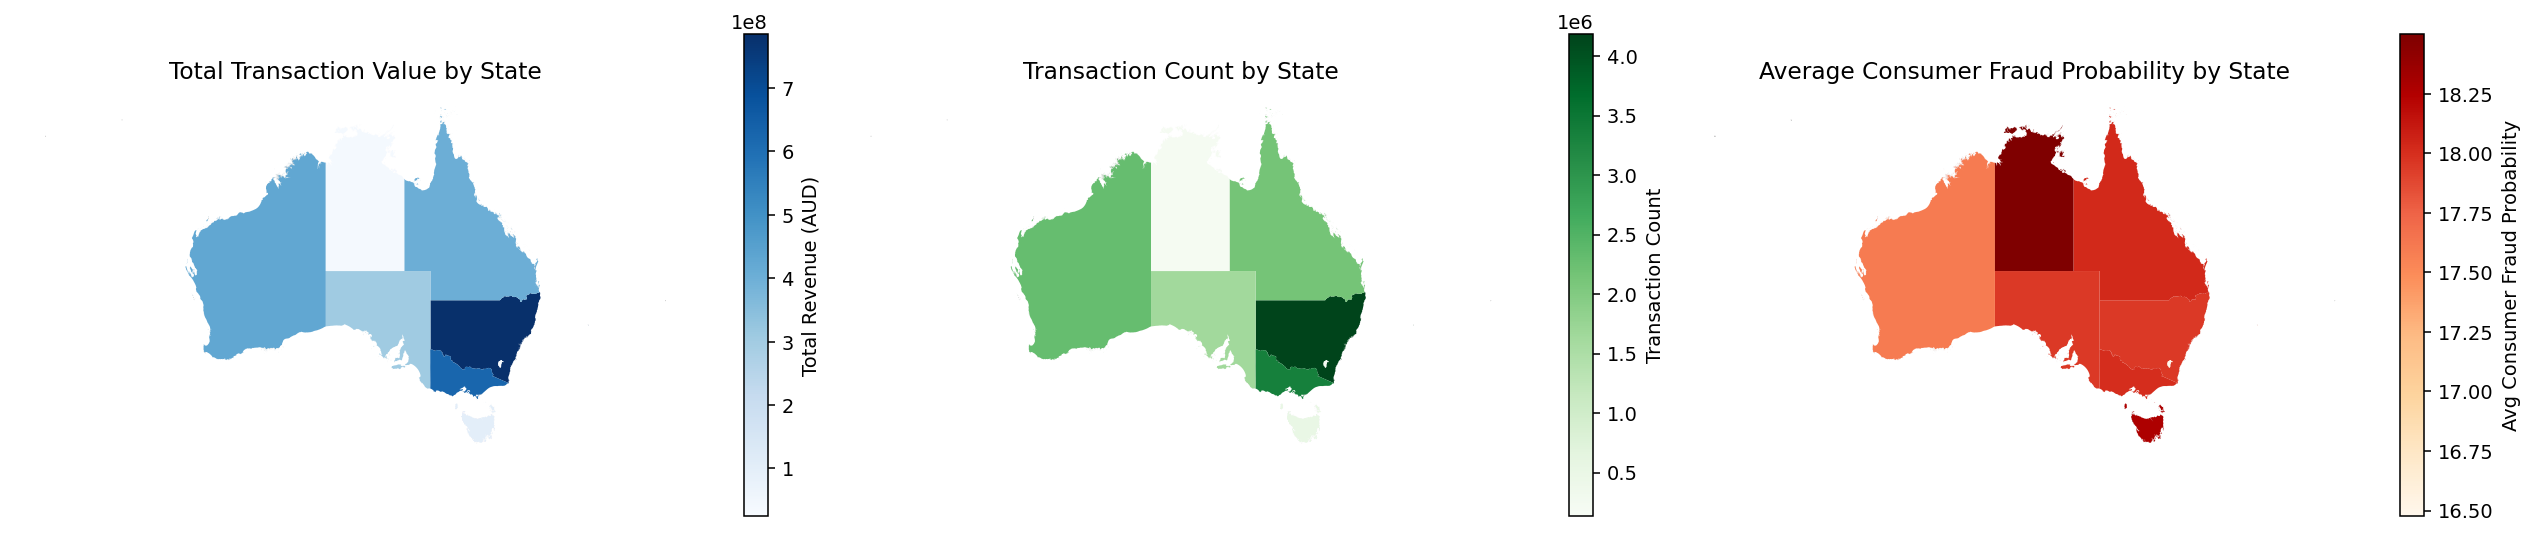

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 合并
gdf_plot = gdf.merge(agg_pd, on="state", how="left")

# 统一地图显示样式
mpl.rcParams["figure.dpi"] = 140

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# 1) 总交易额
gdf_plot.plot(
    column="total_revenue",
    ax=axes[0],
    cmap="Blues",
    legend=True,
    legend_kwds={"label": "Total Revenue (AUD)", "shrink": 0.7},
    missing_kwds={"color":"lightgrey","hatch":"///","label":"No data"}
)
axes[0].set_title("Total Transaction Value by State")
axes[0].axis("off")

# 2) 交易笔数
gdf_plot.plot(
    column="txn_count",
    ax=axes[1],
    cmap="Greens",
    legend=True,
    legend_kwds={"label": "Transaction Count", "shrink": 0.7},
    missing_kwds={"color":"lightgrey","hatch":"///","label":"No data"}
)
axes[1].set_title("Transaction Count by State")
axes[1].axis("off")

# 3) 平均消费者 fraud 概率
gdf_plot.plot(
    column="avg_c_fraud_prob",
    ax=axes[2],
    cmap="OrRd",
    legend=True,
    legend_kwds={"label": "Avg Consumer Fraud Probability", "shrink": 0.7},
    missing_kwds={"color":"lightgrey","hatch":"///","label":"No data"}
)
axes[2].set_title("Average Consumer Fraud Probability by State")
axes[2].axis("off")

# 统一图例中“no data”说明（仅当确实有缺失时才会显示）
handles, labels = axes[2].get_legend_handles_labels()
if "No data" in labels:
    fig.legend(handles, labels, loc="lower center", ncols=4, frameon=False)

plt.show()